# 4. 建模调参

## 4.1 学习目标

    （1） 线性回归模型（对特征的要求）；

    （2）模型评价方法（目标函数、交叉验证、留一验证、学习率曲线、验证曲线）；

    （3）特征选择方法（Lasso回归、Ridge回归、决策树）；

    （4）模型对比（线性模型、非线性模型）
    
    （5）模型参数调节（贪心算法、网格算法、贝叶斯算法）

## 4.2 代码测试

### 4.2.1 读取数据

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [8]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

### 4.2.2 线性回归

In [10]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
model = LinearRegression(normalize=True)

In [13]:
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [15]:
'intercept:'+ str(model.intercept_)

'intercept:-110670.68277277557'

In [16]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641901),
 ('v_8', 700675.5609398846),
 ('v_9', 170630.27723221088),
 ('v_7', 32322.661932023715),
 ('v_12', 20473.670796966464),
 ('v_3', 17868.07954149422),
 ('v_11', 11474.938996741424),
 ('v_13', 11261.764560013271),
 ('v_10', 2683.920090556804),
 ('gearbox', 881.8225039247703),
 ('fuelType', 363.9042507216862),
 ('bodyType', 189.60271012075074),
 ('city', 44.9497512052223),
 ('power', 28.553901616752945),
 ('brand_price_median', 0.5103728134079206),
 ('brand_price_std', 0.4503634709263355),
 ('brand_amount', 0.14881120395065559),
 ('brand_price_max', 0.0031910186703134184),
 ('SaleID', 5.3559899198556306e-05),
 ('seller', 3.312714397907257e-06),
 ('offerType', 2.771965228021145e-06),
 ('train', 4.7206413000822067e-07),
 ('brand_price_sum', -2.175006868187581e-05),
 ('name', -0.00029800127130370817),
 ('used_time', -0.002515894332876499),
 ('brand_price_average', -0.40490484510118563),
 ('brand_price_min', -2.246775348689076),
 ('power_bin', -34.420644117268296),

In [17]:
from matplotlib import pyplot as plt

In [18]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


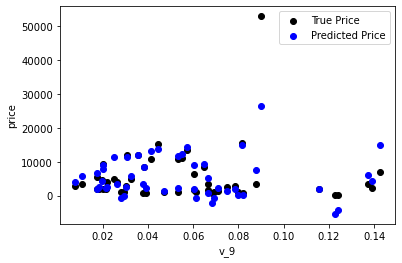

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

It is clear to see the price shows a typical exponential distribution


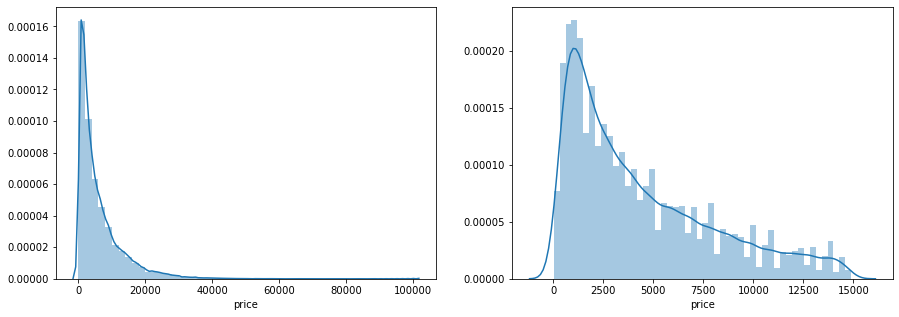

In [21]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。

In [22]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


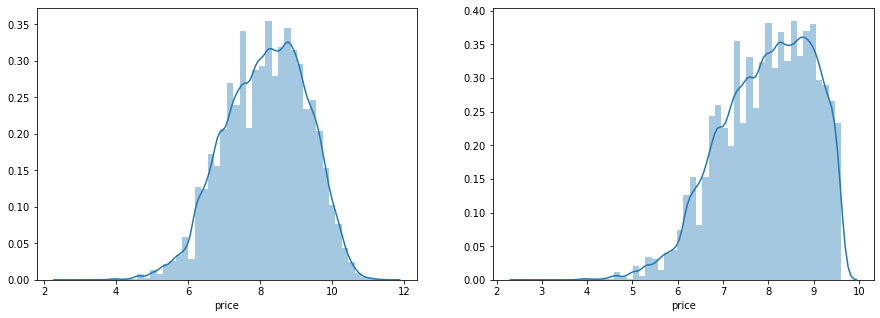

In [23]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

在这里我们对标签进行了log(x+1)变换，使标签贴近于正态分布

In [24]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074946562878


[('v_9', 8.052409900566696),
 ('v_5', 5.764236596649008),
 ('v_12', 1.618208123681179),
 ('v_1', 1.47983105829571),
 ('v_11', 1.1669016563632402),
 ('v_13', 0.9404711296035679),
 ('v_7', 0.7137273083558671),
 ('v_3', 0.68378757710919),
 ('v_0', 0.008500518010181613),
 ('power_bin', 0.008497969302894284),
 ('gearbox', 0.007922377278332254),
 ('fuelType', 0.006684769706827596),
 ('bodyType', 0.004523520092703736),
 ('power', 0.0007161894205356),
 ('brand_price_min', 3.334351114748945e-05),
 ('brand_amount', 2.8978797042774116e-06),
 ('brand_price_median', 1.2571172873021518e-06),
 ('brand_price_std', 6.659176363440789e-07),
 ('brand_price_max', 6.194956307515961e-07),
 ('brand_price_average', 5.999345965047678e-07),
 ('SaleID', 2.119417003964685e-08),
 ('train', -5.879030595679069e-11),
 ('offerType', -1.4210055354624274e-10),
 ('brand_price_sum', -1.5126504215922628e-10),
 ('seller', -1.709388186554861e-10),
 ('name', -7.015512588904125e-08),
 ('used_time', -4.122479372352062e-06),
 ('c

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


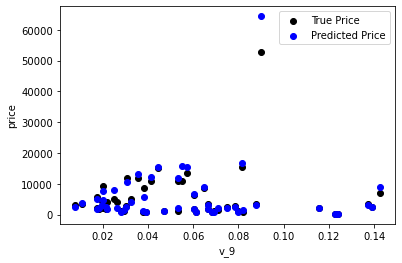

In [25]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

### 4.2.3 五折交叉验证

在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [27]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [28]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）

In [29]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313886


使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）

In [30]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [31]:
print('AVG:', np.mean(scores))

AVG: 0.19325301837047446


In [32]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


### 4.2.3 预测模拟

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大


In [34]:
import datetime

In [35]:
sample_feature = sample_feature.reset_index(drop=True)

In [36]:
split_point = len(sample_feature) // 5 * 4

In [37]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

In [38]:
train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [39]:
model = model.fit(train_X, train_y_ln)

In [40]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270300944

### 4.2.4 制学习率曲线与验证曲线

In [42]:
from sklearn.model_selection import learning_curve, validation_curve

In [44]:
? learning_curve

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'C:\\Users\\d\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

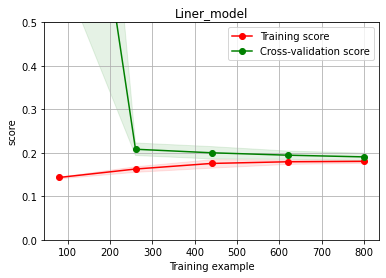

In [46]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

### 4.2.5 多种模型对比

In [47]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)